In [1]:
# Necesarry imports
import pandas as pd
from sklearn import svm, linear_model
from sklearn.utils import shuffle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
# settings to display all columns
pd.set_option("display.max_columns", None)

In [2]:
C = ["XS", "S", "M", "L"]

In [3]:
final_df = pd.read_csv("../data/final_dataset.csv")

/Users/luca/mambaforge/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (4,21,22,114) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
car_df = final_df[final_df["vehicleType"] == "car"]

# Add the vehicle class
classes = { 'BMW 1er': "M",
 'BMW 2er Active Tourer': "M", 'BMW 2er Cabrio': "L", 'BMW I3': "M",
       'BMW X1': "L", 'BMW X2': "L", 'MINI 3-tuerer': "S", 'MINI 5-tuerer': "S",
       'MINI Cabrio': "S", 'MINI Clubman': "S", 'MINI Countryman': "S",
       'Mercedes-Benz A-Klasse': "M", 'Mercedes-Benz B-Klasse': "M",
       'Mercedes-Benz GLA': "M", 'bmw 1er': "M", 'bmw 2er active tourer': "M",
       'bmw 2er cabrio': "L", 'bmw i3': "M", 'bmw x1': "L", 'bmw x2': "L", 'mini 3-tuerer': "S",
       'mini 5-tuerer': "S", 'mini cabrio': "S", 'mini clubman': "S", 'mini countryman': "S",
       'smart fortwo 3rd generation': "XS"}

car_df["class"] = car_df["model"].apply(lambda model: classes[model])

/var/folders/6z/4wrrwt1921s955ylw5cdq15m0000gn/T/ipykernel_54379/631624269.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df["class"] = car_df["model"].apply(lambda model: classes[model])


In [5]:
age_src_columns = ["Unter 18", "18 - 29","30 - 49","50 - 64","65 und älter"]
hh_src_columns = ["Einpersonenhaushalte (Singlehaushalte)", "Paare ohne Kind(er)", "Alleinerziehende Elternteile", "Paare mit Kind(ern)", "Mehrpersonenhaushalte ohne Kernfamilie"]

tmp_df = car_df[[*age_src_columns, *hh_src_columns, "distance", "class", "Bezirk"]]

# Calculate the distribution classes
def calculate_dist(columns: list[str], prefix: str):
  sum = tmp_df[columns].sum(axis=1)
  for (i, c) in enumerate(columns):
    tmp_df[f"{prefix}_{i + 1}"] = (tmp_df[c] / sum)

calculate_dist(age_src_columns, "age")
calculate_dist(hh_src_columns, "hh")

# Now drop the unused classes
learning_df = tmp_df.drop([*age_src_columns, *hh_src_columns, "Bezirk"], axis=1)

# Also drop malformed entries
learning_df.dropna(inplace=True)

/var/folders/6z/4wrrwt1921s955ylw5cdq15m0000gn/T/ipykernel_54379/590529843.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df[f"{prefix}_{i + 1}"] = (tmp_df[c] / sum)


In [6]:
# Also create the bezirks data for the stations in the simulation stage
bezirk_df = tmp_df.drop([*age_src_columns, *hh_src_columns, "class", "distance"], axis=1)
print(bezirk_df.groupby("Bezirk").count().sort_values("age_1"))
bezirk_df = bezirk_df.groupby("Bezirk").mean()

# Aaand normalize columns
def normalize_columns(columns):
  sum = bezirk_df[columns].sum(axis=1)
  for c in columns:
    bezirk_df[c] = bezirk_df[c] / sum

normalize_columns([f"age_{i}" for i in range(1, 6)])
normalize_columns([f"hh_{i}" for i in range(1, 6)])


                             age_1   age_2   age_3   age_4   age_5    hh_1  \
Bezirk                                                                       
Marzahn-Hellersdorf           1411    1411    1411    1411    1411    1411   
Spandau                      30524   30524   30524   30524   30524   30524   
Treptow-Köpenick             34915   34915   34915   34915   34915   28163   
Reinickendorf                55422   55422   55422   55422   55422   53897   
Lichtenberg                  65295   65295   65295   65295   65295   64832   
Steglitz-Zehlendorf          91244   91244   91244   91244   91244   89379   
Neukölln                    117170  117170  117170  117170  117170  115628   
Tempelhof-Schöneberg        198518  198518  198518  198518  198518  197847   
Pankow                      216460  216460  216460  216460  216460  216203   
Charlottenburg-Wilmersdorf  327215  327215  327215  327215  327215  322800   
Friedrichshain-Kreuzberg    340491  340491  340491  340491  3404

In [7]:
header = ["Under 18 Years", "18-29 Years", "30-49 Years", "50-64 Years", "Over 65 Years", "Single Household", "Pairs", "Single Parents", "Parents with children", "Multiperson household"]
# bezirk_df[[f"hh_{i}" for i in range(1, 6)]].sum(axis=1)
bezirk_df.to_latex("../paper/Appendices/district-table.tex", header=header, longtable=True, label="table:Districts", float_format="%.2f")

In [8]:
bezirk_df

,age_1,age_2,age_3,age_4,age_5,hh_1,hh_2,hh_3,hh_4,hh_5
Bezirk,,,,,,,,,,
Charlottenburg-Wilmersdorf,0.123084,0.140940,0.303421,0.230224,0.202331,0.555159,0.202011,0.074154,0.135922,0.032754
Friedrichshain-Kreuzberg,0.139032,0.227621,0.401664,0.143107,0.088576,0.535791,0.148643,0.074135,0.133834,0.107596
Lichtenberg,0.134709,0.228394,0.316003,0.155271,0.165623,0.490168,0.240385,0.091568,0.137804,0.040073
Marzahn-Hellersdorf,0.053946,0.073412,0.338088,0.265322,0.269231,0.254053,0.637242,0.016507,0.091414,0.000783
Mitte,0.136112,0.202399,0.362449,0.174926,0.124114,0.563059,0.169525,0.070242,0.132560,0.064615
Neukölln,0.151298,0.230332,0.350282,0.157846,0.110242,0.543705,0.156648,0.077594,0.129284,0.092768
Pankow,0.153471,0.176441,0.456331,0.113997,0.099759,0.546312,0.174585,0.084311,0.138146,0.056646
Reinickendorf,0.150823,0.154017,0.291188,0.188156,0.215815,0.492691,0.205778,0.132443,0.120349,0.048739
Spandau,0.122691,0.166697,0.284365,0.236353,0.189894,0.562037,0.206568,0.084230,0.126838,0.020327


In [9]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1983246 entries, 303541 to 2636051
Columns: 139 entries, id to class
dtypes: bool(3), float64(94), int64(16), object(26)
memory usage: 2.0+ GB


In [10]:
simulation_districts = ["Pankow", "Reinickendorf", "Friedrichshain-Kreuzberg", "Charlottenburg-Wilmersdorf"]

relevant_data = car_df.loc[car_df["Bezirk"].isin(simulation_districts), "datetime_start"]

r = pd.to_datetime(relevant_data,errors='coerce', utc=True)
hour_df = pd.DataFrame(data={"day": r.dt.date, "hour": r.dt.hour, "id": relevant_data.index})

In [11]:
hour_df

,day,hour,id
303542,2020-01-17,11,303542
303545,2020-01-18,3,303545
303550,2020-01-19,17,303550
303552,2020-01-20,20,303552
303553,2020-01-20,20,303553
...,...,...,...
2636033,2019-10-29,14,2636033
2636041,2019-11-04,16,2636041
2636042,2020-01-04,12,2636042
2636049,2019-11-03,14,2636049


Text(0, 0.5, 'Average number of rentals')

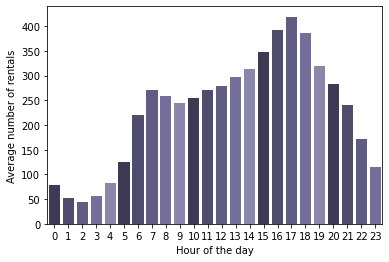

In [12]:
hd = hour_df.groupby(["day", "hour"]).count()
# palette = sns.light_palette("#786fa6")
# sns.barplot(x=hd.index, y=hd.values, palette=palette
daily_demand = hd.groupby("hour").mean().round()

palette = sns.color_palette(["#3B3659", "#4C4672", "#5C558B", "#6F67A2", "#8781B1"])
sns.barplot(data=daily_demand, x=daily_demand.index, y="id", palette=palette)
plt.xlabel("Hour of the day")
plt.ylabel("Average number of rentals")

In [13]:
start = pd.to_datetime(car_df["datetime_start"], utc=True)
end = pd.to_datetime(car_df["datetime_end"], utc=True)

In [14]:
diff = car_df["distance"] / (end - start).dt.seconds
diff = diff * 60

In [15]:
diff.replace([np.inf, -np.inf], np.nan).dropna().mean()

126.39280907696697

In [16]:
car_df["distance"].mean()

4451.397745641143

In [17]:
# Figure out the availability of classes
unique_cars = car_df.groupby("class")["id"].nunique()
num_of_dp = learning_df.groupby("class")["class"].count()
min_class = num_of_dp.idxmin()


def truncate_shuffle(c):
  num = num_of_dp[c]
  unique = unique_cars[c]

  scale = unique_cars[c] / unique_cars[min_class]
  truncated_num = round(scale * num_of_dp[min_class])

  a = learning_df.loc[learning_df["class"] == c, :]
  shuffle(a)
  a = a[:80000] # truncated_num

  print(c, num, unique, scale, truncated_num, a.shape)
  return a

# learning_df = pd.concat([truncate_shuffle(c) for c in C])

In [18]:
learning_df.groupby("class").count()

,distance,age_1,age_2,age_3,age_4,age_5,hh_1,hh_2,hh_3,hh_4,hh_5
class,,,,,,,,,,,
L,75073,75073,75073,75073,75073,75073,75073,75073,75073,75073,75073
M,369569,369569,369569,369569,369569,369569,369569,369569,369569,369569,369569
S,423767,423767,423767,423767,423767,423767,423767,423767,423767,423767,423767
XS,1082807,1082807,1082807,1082807,1082807,1082807,1082807,1082807,1082807,1082807,1082807


In [19]:
# Training a classifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

X = learning_df.loc[:, learning_df.columns != "class"]
Y = learning_df.loc[:, learning_df.columns == "class"]["class"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

clf = make_pipeline(MinMaxScaler(), ComplementNB())
clf.fit(X_train.values, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('complementnb', ComplementNB())])

In [20]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train.values, y_train)

/Users/luca/mambaforge/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:24:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=10,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

nn_clf = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, max_iter=1200))
nn_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(max_iter=1200, random_state=1))])

In [22]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

sgd_clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3, class_weight="balanced", loss="log"))

sgd_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(class_weight='balanced', loss='log'))])

In [23]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.inspection import permutation_importance
 
# Test the classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

imps = permutation_importance(clf, X_test, y_test)
print(imps.importances_mean)

/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           L       0.04      0.03      0.03     24819
           M       0.20      0.03      0.05    122052
           S       0.22      0.50      0.31    140145
          XS       0.57      0.48      0.52    356886

    accuracy                           0.38    643902
   macro avg       0.26      0.26      0.23    643902
weighted avg       0.40      0.38      0.37    643902



/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/luca/mambaforge/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fi

[-9.93318859e-04  2.90727471e-04  1.27969784e-03  5.14426108e-03
  4.68984411e-03  2.40347134e-03  1.32939485e-04 -7.20606552e-05
  1.41108430e-03 -3.20172946e-03 -1.27659178e-04]


In [24]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
# Test the classifier
y_pred = sgd_clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           L       0.05      0.01      0.02     24819
           M       0.22      0.00      0.01    122052
           S       0.25      0.00      0.01    140145
          XS       0.56      0.99      0.71    356886

    accuracy                           0.55    643902
   macro avg       0.27      0.25      0.19    643902
weighted avg       0.40      0.55      0.40    643902



In [25]:
from simulation import Simulation

p = 1 / daily_demand["id"]
station_data = bezirk_df.loc[bezirk_df.index.isin(simulation_districts), :]



In [26]:
alpha_r = [(alpha, Simulation(station_data=station_data, p=p, alpha=alpha, capacity=5, pred=clf.predict_proba)) for alpha in np.arange(0.01, 0.05, 0.002)]

In [27]:
alpha_df = pd.DataFrame(data=map(lambda a: [a[0], a[1].td, a[1].urr, a[1].pi], alpha_r), columns=["alpha", "TD", "URR", "PI"])
alpha_df["alpha"] = alpha_df["alpha"].round(3)

In [34]:
capacity_r = [(c, Simulation(station_data=station_data, p=p, alpha=0.05, capacity=c, pred=clf.predict_proba)) for c in np.arange(2, 50, 2)]

In [35]:
capacity_df = pd.DataFrame(data=map(lambda a: [a[0], a[1].td, a[1].urr, a[1].pi], capacity_r), columns=["Capacity", "TD", "URR", "PI"])

<AxesSubplot:xlabel='Capacity', ylabel='PI'>

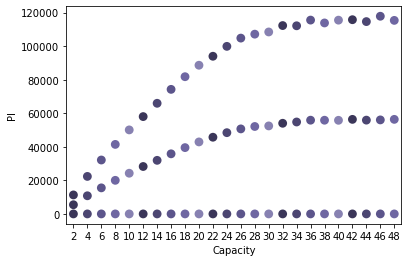

In [36]:
sns.pointplot(x=capacity_df["Capacity"], y=capacity_df["TD"], palette=palette)
sns.pointplot(x=capacity_df["Capacity"], y=capacity_df["URR"], palette=palette)
sns.pointplot(x=capacity_df["Capacity"], y=capacity_df["PI"], palette=palette)

In [75]:
def metric_plot(df, index, xlabel):
  fig, ax = plt.subplots(1, 3, figsize=(21, 7),constrained_layout=True )
  c = ["#4C4672", "#5C558B", "#6F67A2"]
  
  sns.pointplot(x=df[index], y=capacity_df["URR"], color=c[0], ax=ax[0])
  sns.pointplot(x=df[index], y=capacity_df["PI"], color=c[1], ax=ax[1])
  sns.pointplot(x=df[index], y=capacity_df["TD"], color=c[2], ax=ax[2])
  fig.autofmt_xdate()
  for a in ax:
    a.set_xlabel(xlabel)


/var/folders/6z/4wrrwt1921s955ylw5cdq15m0000gn/T/ipykernel_54379/4052303868.py:8: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.autofmt_xdate()


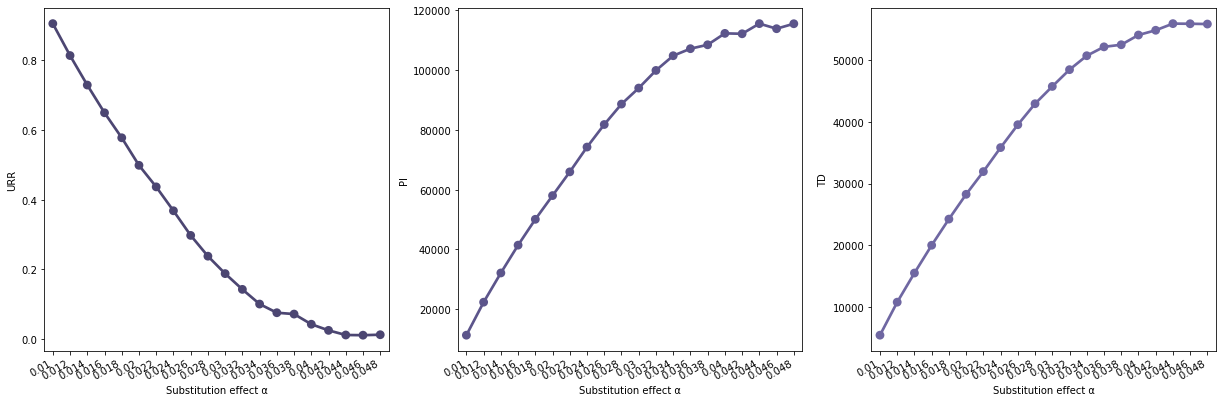

In [77]:
metric_plot(alpha_df, "alpha", "Substitution effect α") # "α"

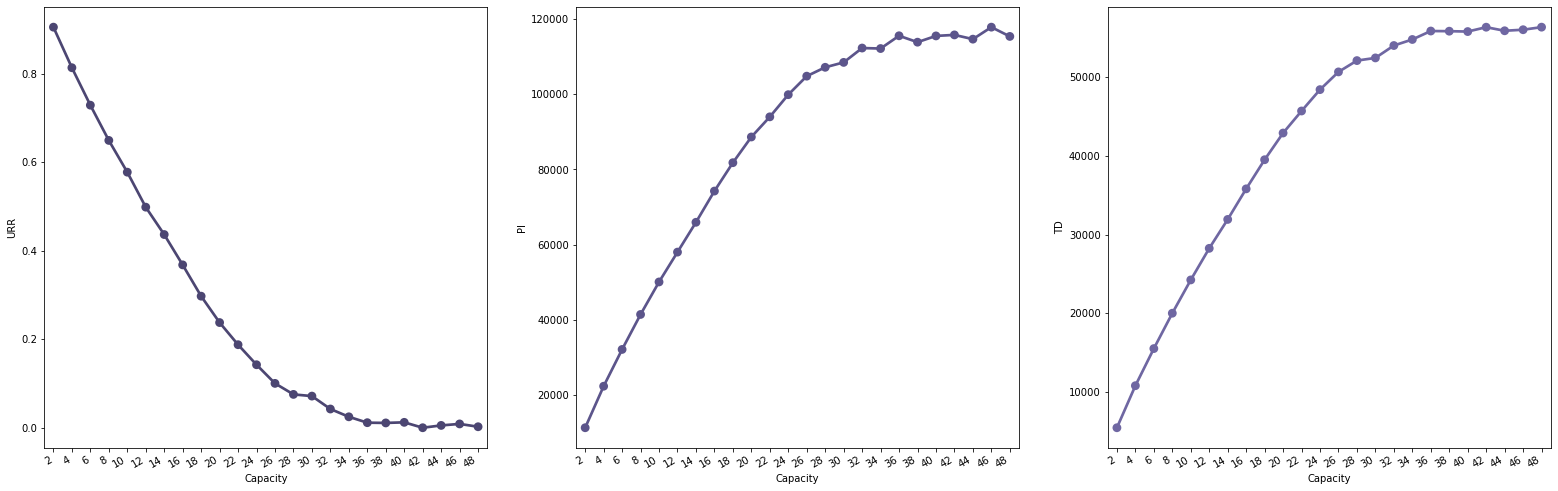

In [39]:
metric_plot(capacity_df, "Capacity")

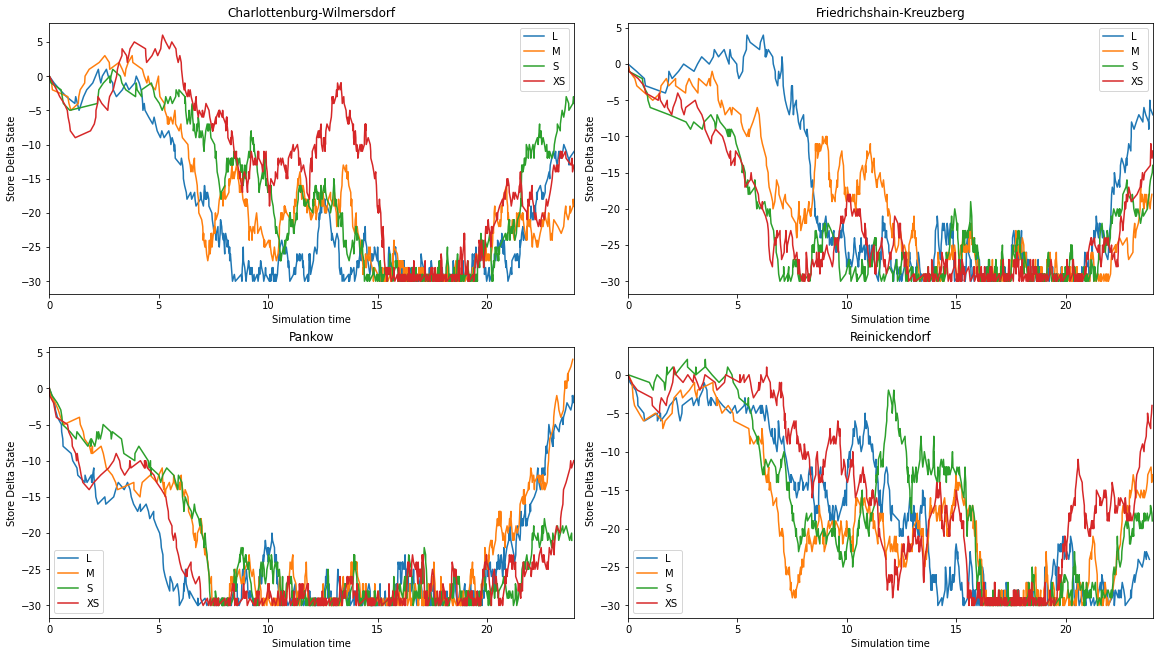

In [78]:
s = Simulation(station_data=station_data, p=p, alpha=0.003, capacity=30, pred=clf.predict_proba)

fig, axs = plt.subplots(2, 2, figsize=(16, 9), constrained_layout=True )
for station, ax in zip(s.stations, axs.flatten()):
  # ax = axs[i]
  # This is just for the ide
  ax: plt.Axes = ax
  ax.set_title(station.name)
  ax.set_xlim(0, 24)
  ax.set_xlabel("Simulation time")
  ax.set_ylabel("Store Delta State")
  for (c, df) in station.history_df.items():
    sns.lineplot(x=df.index / 60, y=df["amount"].values, ax=ax)
  ax.legend(labels=station.history_df.keys())

In [79]:
s.print_metrics()

URR: 6.50%
Profit: 110367.929€
Total distance driven: 53001.800km


In [ ]:
sgd_clf.predict_proba([[5, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]])
  

In [ ]:
X

In [ ]:
def age_class(i, name):
  car_df[f"age_{i}"] = car_df[name] / car_df["Einheiten insgesamt"]

age_class(1, "Unter 18")
age_class(2, "18 - 29")
age_class(3, "30 - 49")
age_class(4, "50 - 64")
age_class(5, "65 und älter")


In [ ]:
income_curr = ["Erwerbstätige / Monatliches Nettoeinkommen unter 900", "Erwerbstätige / Monatliches Nettoeinkommen 900 – 1500", "Erwerbstätige / Monatliches Nettoeinkommen 1500 und mehr"]

car_df["income_total"] = car_df[income_curr].sum(axis=1)

def income_class(i, name):
  car_df[f"income_{i}"] = car_df[name] / car_df["income_total"]

for (i, name) in enumerate(income_curr):
  income_class(i + 1, name)

In [ ]:
car_df.head()

In [ ]:
classes = { 'BMW 1er': "M",
 'BMW 2er Active Tourer': "M", 'BMW 2er Cabrio': "L", 'BMW I3': "M",
       'BMW X1': "L", 'BMW X2': "L", 'MINI 3-tuerer': "S", 'MINI 5-tuerer': "S",
       'MINI Cabrio': "S", 'MINI Clubman': "S", 'MINI Countryman': "S",
       'Mercedes-Benz A-Klasse': "M", 'Mercedes-Benz B-Klasse': "M",
       'Mercedes-Benz GLA': "M", 'bmw 1er': "M", 'bmw 2er active tourer': "M",
       'bmw 2er cabrio': "L", 'bmw i3': "M", 'bmw x1': "L", 'bmw x2': "L", 'mini 3-tuerer': "S",
       'mini 5-tuerer': "S", 'mini cabrio': "S", 'mini clubman': "S", 'mini countryman': "S",
       'smart fortwo 3rd generation': "XS"}

car_df["class"] = car_df["model"].apply(lambda model: classes[model])

In [ ]:
age_columns = [f"age_{i}" for i in range(1, 6)]
income_columns = [f"income_{i}" for i in range(1, 4)]

fdf = car_df[[*age_columns, *income_columns, "class"]]

In [ ]:
# "XS" is overpopulated
sns.countplot(data=car_df, x="model", order=C)

In [ ]:
sns.displot(car_df, x="distance")

In [ ]:
# palette = sns.light_palette("#786fa6")
ax = sns.boxplot(data=learning_df, palette=palette)


In [ ]:
car_df["model_lc"] = car_df["model"].apply(lambda a: a.lower())


In [ ]:

plt.figure(figsize=(8,4)) # this creates a figure 8 inch wide, 4 inch high

palette = sns.light_palette("#786fa6")ax = sns.countplot(data=car_df, x="model_lc", palette=palette, order=car_df["model_lc"].value_counts().index)
ax.set_ylim(0, 1200000)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Model class name")
plt.ylabel("Number of rentals")
plt.show()

In [ ]:
car_df["model_lc"].value_counts()[1:].sum()

In [ ]:
fleet_size = car_df[["model_lc", "id"]].groupby("model_lc").nunique()
fleet_size.sort_values(by="id", ascending=False, inplace=True)

ax = sns.barplot(x=fleet_size.index, y=fleet_size.values.reshape(1, -1)[0], palette=palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.xlabel("Model class name")
plt.ylabel("Number of unique vehicles")
plt.show()
# fleet_size.index, fleet_size.values.reshape(1, -1)[0]


In [ ]:
fleet_size

In [ ]:
fleet_ids = fleet_size["id"]
fleet_size.max(), fleet_size.min(), fleet_size.sum(), fleet_size

In [ ]:
count = fdf.groupby("class").count().min(axis=1).min()

def truncate_class(c):
  a = fdf[fdf["class"] == c];
  shuffle(a)
  a = a[:count]
  return a

fdf = pd.concat([truncate_class(c) for c in C])
fdf.dropna(inplace=True)

In [ ]:
# now not anymore
sns.countplot(data=fdf, x="class", order=C)

In [ ]:

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

X = fdf[[*age_columns, *income_columns]]
Y = fdf["class"]

# Oversample using SMOTE
# sm = SMOTE(random_state=42)
# x_smote, y_smote = sm.fit_resample(X, Y)

# enn = EditedNearestNeighbours()
# x_train_enn, y_train_enn = enn.fit_resample(X, Y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
clf_classes = clf.classes_

In [ ]:
clf_classes

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
 
# Test the classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

In [ ]:
print(classification_report(y_test,y_pred))
# print(accuracy_score(y_test,y_pred))
# print("Precision Score : ",precision_score(y_test,y_pred, 
#                                            pos_label='positive',
#                                            average='micro'))
# print("Recall Score : ",recall_score(y_test,y_pred, 
#                                            pos_label='positive',
#                                            average='micro'))

In [ ]:
import seaborn as sns


In [ ]:
districts = car_df[["Bezirk", *age_columns, *income_columns]].groupby("Bezirk")
districts = districts.mean()
districts

In [ ]:
# Figure out and normalize data per sector
def normalize_columns(columns):
  total = districts[columns].sum(axis=1)
  for c in columns:
    districts[c] = districts[c] / total

normalize_columns(age_columns)
normalize_columns(income_columns)

In [ ]:
districts

In [ ]:
def predice_choices(d, alpha):
  p = clf.predict_proba([d])[0]
  i = p.argmax()
  print(p)
  p_max = p[i]

  choices = filter(lambda a: p[a[0]] >= p_max - alpha, enumerate(clf_classes))
  choices = map(lambda a: a[1], choices)

  return list(choices)


def predict_district(name: str, alpha: float):
  return predice_choices(districts.loc[name][[*age_columns, *income_columns]], alpha)
  

print([(on, predict_district(on, 0.04)) for on in districts.index])



In [ ]:
dt = pd.to_datetime(car_df["datetime_start"][0:50000], errors="raise")  
dt

In [ ]:
v = car_df[0:50000].groupby(dt.dt.hour).count()["id"]
sns.barplot(x=v.index, y=v.values, palette=palette)

plt.xlabel("Hour of the day")
plt.ylabel("Rides")

In [ ]:
dt

In [ ]:
predice_choices([0, 1, 0, 0, 0, 0, 0, 1], 0.1), clf_classes

In [ ]:
predice_choices([0, 0, 0, 1, 0, 0, 1, 0], 0.1), clf_classes

In [ ]:
predice_choices([0, 0, 0.3, 0, 0, 0, 0, 1], 0.1), clf_classes

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
cross_val_score(XGBClassifier(), X_train, y_train)

In [ ]:
times = car_df[["datetime_start", "datetime_end"]]
times.min(), times.max()

In [ ]:
car_df["provider"].unique()

In [ ]:
car_df